## <font color='red'> Code to find the ground state of the Schwinger model using the MBVQE circuit </font>

#### &copy; Abhijit Chakraborty

In [94]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import random
from numpy import linalg as LA
np.set_printoptions(suppress=True)

In [95]:
from scipy.linalg import expm

In [96]:
N = int(input('Enter number of lattice sites: '))

Enter number of lattice sites: 4


In [97]:
layers = int(input('Enter number of layers for VQE: '))

Enter number of layers for VQE: 3


In [98]:
size = 2**N

### Building the VQE Circuit

In [99]:
def single_rot_z(theta):
    sigmaz = np.array([[1,0],[0,-1]])
    return expm(-1j*(theta/2)*sigmaz)

In [100]:
def single_rot_x(theta):
    sigmax = np.array([[0,1],[1,0]])
    return expm(-1j*(theta/2)*sigmax)

In [101]:
def var_layer(params):
    prod = [1]
    for i in range(N):
        rot = np.matmul(single_rot_x(params[2*i+1]), single_rot_z(params[2*i]))
        prod = np.kron(prod,rot)
    return prod    

In [102]:
def cnot():
    return [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

In [103]:
def cnot_layer1():
    prod = [1]
    for i in range(int(N/2)):
        prod = np.kron(prod,cnot())
    return prod

In [104]:
def cnot_layer2():
    prod = np.eye(2)
    for i in range(1,int(N/2)):
        prod = np.kron(prod,cnot())
    prod = np.kron(prod,np.eye(2))
    return prod

In [105]:
def single_layer_vqe(params):
    temp = np.matmul(cnot_layer1(),var_layer(params))
    temp = np.matmul(cnot_layer2(),temp)
    return temp

In [106]:
def full_vqe(thetas):
    temp = np.eye(16)
    for i in range(layers):
        params = thetas[2*i*N:2*(i+1)*N]
        temp = np.matmul(single_layer_vqe(params),temp)
        
    initial_state = [1./2**(N/2) for _ in range(size)]
    final_state = np.matmul(temp,initial_state)
    return final_state

### Cost function calculation

In [107]:
def lattperm(n):
    size = 2**n
    binarr = [None]*size
    
    for i in range(size):
        binarr[i] = bin(i)[2:]
        l = len(binarr[i])
        if l<n:
            for j in range(n-l):
                binarr[i] = '0' + binarr[i]
        binarr[i] = list(map(int,list(binarr[i])))
        
    return binarr

In [108]:
binarr = lattperm(N)
def lat_to_spin(arr):
    n = len(arr)
    spinarr = [[0]*N for _ in range(n)]
    for i in range(n):
        for j in range(N):
            if j%2==0:
                if arr[i][j] == 0:
                    spin = 1
                else:
                    spin = -1
            else:
                if arr[i][j] == 0:
                    spin = -1
                else:
                    spin = 1
            spinarr[i][j] = spin
    return spinarr

spinarr = lat_to_spin(binarr)

In [109]:
def hamiltonianM(m,spinstr):
    eng = 0
    for i in range(1,N+1):
        
        if i%2==1:
            eng += -(m/2)*spinstr[i-1]
        else:
            eng += (m/2)*spinstr[i-1]
    
    return eng + m*N/2

In [110]:
def HZJ(J,spinstr):
    tot = 0
    for n in range(1,N):
        sigma_z = 0
        if n%2 == 1:
            for j in range(n):
                sigma_z += spinstr[j]
        tot += sigma_z
        
    return tot*J/2.0

In [111]:
def corrHam(J,spinstr):
    tot = 0
    for n in range(1,N-1):
        for l in range (n+1,N):
            tot += J*(N-l)*spinstr[n-1]*spinstr[l-1]/2
    return tot

In [112]:
def energy_diag(m,J,spinarr,hm):
    size = 2**N
    for i in range(size):
        hm[i][i] = corrHam(J,spinarr[i]) + hamiltonianM(m,spinarr[i]) - HZJ(J,spinarr[i])
        
    return  

In [113]:
def find_ind(spinarr,n,i):
    tempspin = list(spinarr[i])
    tempspin[n], tempspin[n+1] = tempspin[n+1], tempspin[n]
    j = spinarr.index(tempspin)
    
    return j

In [114]:
def flipflop(w,spinarr,hm):
    
    for i in range(size):
        for j in range(N-1):
            if spinarr[i][j]*spinarr[i][j+1]==-1:
                ind = find_ind(spinarr,j,i)
                hm[i][ind] = w
    return

In [115]:
# This is the cost function and calcualtes the energy expectation value

def energy_exp(thetas):
    
    final_state = full_vqe(thetas)
    temp1 = np.matmul(htarget,final_state)
    temp2 = np.real(np.dot(np.conj(final_state),temp1))
    
    return temp2

#### Defining the order parameter to plot the phase transition plot 

In [116]:
def order_param(spinstr):
    tot = 0.0
    for i in range(N):
        if (i+1)%2==0:
            fterm = 1 + spinstr[i]
        else:    
            fterm = 1 - spinstr[i]
        for j in range(i+1,N):
            if (j+1)%2==0:
                sterm = 1 + spinstr[j]
            else:    
                sterm = 1 - spinstr[j] 
            tot += fterm*sterm
            
    return tot/(2*N*(N-1))

### VQE optimization steps

In [117]:
from scipy.optimize import minimize

In [120]:
mvals = np.linspace(5,-5,num=10)
order_list = []
occupation_list = []
thetas = np.array([random.uniform(0,1) for i in range(2*N*layers)])
for m in mvals:
    w = 1.0
    J = 1.0
    htarget = np.zeros((size,size))
    energy_diag(m,J,spinarr,htarget)
    flipflop(w,spinarr,htarget)
    #thetas = np.array([random.uniform(0,1) for i in range((int(N/2)+1)*layers)])
    res = minimize(energy_exp,thetas,method = 'BFGS')
    #res = differential_evolution(energy_exp, bounds)
    vec = full_vqe(res.x)
    tot = 0.0
    occ = 0.0
    for i in range(size):
        tot += order_param(spinarr[i])*abs(vec[i])*abs(vec[i])
        occ += sum(binarr[i])*abs(vec[i])*abs(vec[i])
    order_list.append(tot) 
    occupation_list.append(occ)
    thetas = res.x + np.array([random.uniform(0,0.1) for i in range(2*N*layers)])

### Plot of the order parameter and occupation number with bare mass

In [121]:
plt.rcParams.update({'font.size': 14, 'font.weight':'normal', 'font.family': 'sans-serif'})

Text(0, 0.5, 'Order parameter')

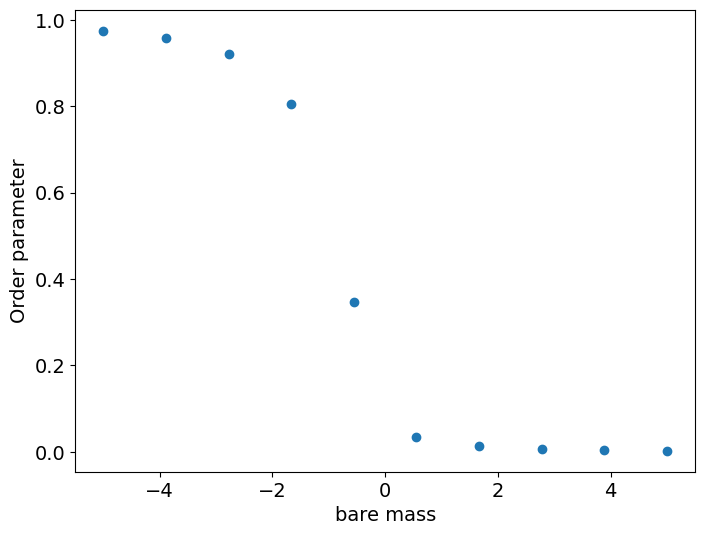

In [124]:
plt.figure(figsize=(8,6))
plt.plot(mvals,order_list,'o')
plt.xlabel('bare mass')
plt.ylabel('Order parameter')

Text(0, 0.5, 'Occupation Number')

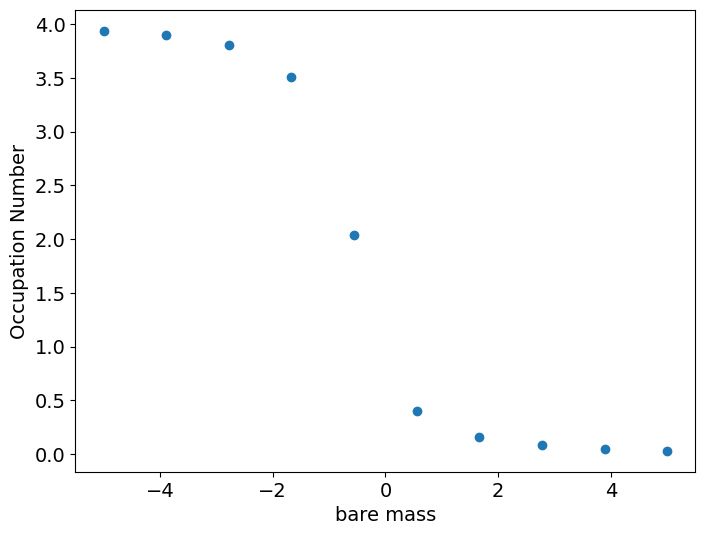

In [126]:
plt.figure(figsize=(8,6))
plt.plot(mvals,occupation_list,'o')
plt.xlabel('bare mass')
plt.ylabel('Occupation Number')

## Exact diagonalization and VQE together

In [127]:
def ground_state(ht):
    w, v = LA.eig(ht)
    min_eig = min(w)
    ind = np.where(w==min_eig)[0][0]
    
    return min_eig, v[:,ind]

In [128]:
order_list_ED = []
occupation_list_ED = []
mvals2 = np.linspace(-5,5,num=50)
for m in mvals2:
    w = 1.0
    J = 1.0
    htarget = np.zeros((size,size))
    energy_diag(m,J,spinarr,htarget)
    flipflop(w,spinarr,htarget)
    eig, vec = ground_state(htarget)
    #print(vec)
    tot = 0.0
    occ = 0.0
    for i in range(size):
        tot += order_param(spinarr[i])*vec[i]*vec[i]
        occ += sum(binarr[i])*vec[i]*vec[i]
    order_list_ED.append(tot) 
    occupation_list_ED.append(occ)

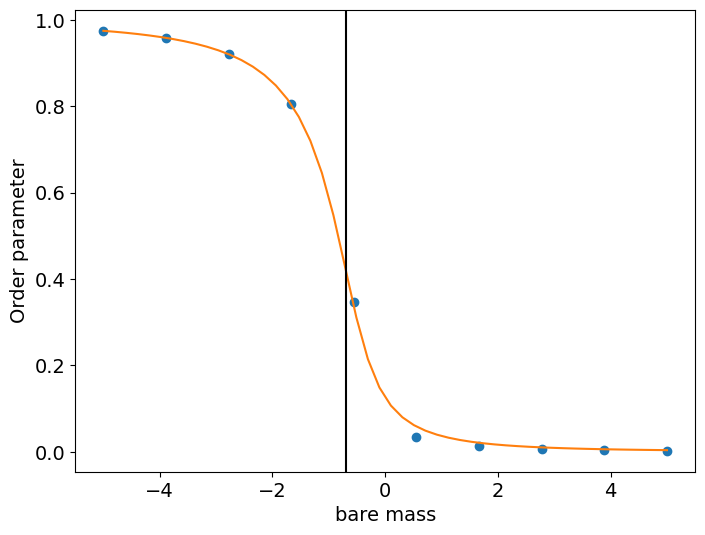

In [132]:
plt.figure(figsize=(8,6))
plt.plot(mvals,order_list,'o')
plt.plot(mvals2,order_list_ED,'-')
plt.axvline(x=-0.7,color='black')
plt.xlabel('bare mass')
plt.ylabel('Order parameter')
plt.savefig('order_parameter_ED_vs_MBVQE.png')

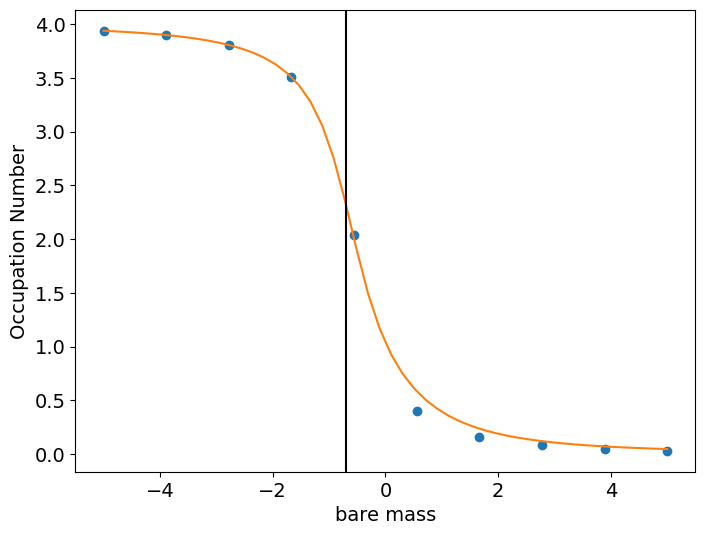

In [133]:
plt.figure(figsize=(8,6))
plt.plot(mvals,occupation_list,'o')
plt.plot(mvals2,occupation_list_ED,'-')
plt.axvline(x=-0.7,color='black')
plt.xlabel('bare mass')
plt.ylabel('Occupation Number')
plt.savefig('Occupation_Number_ED_vs_MBVQE.png')